# LLM Text Preprocessing Foundations — Embeddings

This notebook follows the core ideas from Chapter 2 of *Build a Large Language Model (From Scratch)* (Sebastian Raschka) and focuses on the practical steps needed to prepare text for LLM training.

**Objectives**
- Load raw text data and tokenize it into integer token IDs
- Build next-token prediction training samples using a sliding window (`max_length`, `stride`)
- Convert token IDs into vectors using embedding layers (token + positional embeddings)
- Run a small experiment showing how `max_length` and `stride` affect the number of training samples


## 1) Set up environment

We need a few core packages:
- `torch` for embedding layers and tensor utilities
- `tiktoken` for a fast GPT-2-compatible BPE tokenizer
- `matplotlib` to visualize how sampling choices affect dataset size

If you run this in VS Code, you may need to restart the kernel after installation.


In [1]:
%pip install -q numpy torch tiktoken matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from importlib.metadata import version

import numpy as np
import torch
import tiktoken

print("torch:", version("torch"))
print("tiktoken:", version("tiktoken"))

torch: 2.10.0
tiktoken: 0.12.0


## 2) Load raw text

LLMs learn statistical patterns from large amounts of text.
Before we can train, we need a reliable way to load the raw corpus.

Keeping paths *repo-relative* makes experiments reproducible across machines.


In [3]:
from pathlib import Path
import requests

# Reproducibility (helps when comparing experiments)
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

ROOT = Path.cwd()
DATA_PATH = ROOT / "the-verdict.txt"

if not DATA_PATH.exists():
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt"
    )
    resp = requests.get(url, timeout=30)
    resp.raise_for_status()
    DATA_PATH.write_bytes(resp.content)

raw_text = DATA_PATH.read_text(encoding="utf-8")
print("Characters:", len(raw_text))
print(raw_text[:120])

Characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me 


## 3) Tokenization → token IDs

Neural networks operate on numbers, not raw strings.
Tokenization converts text into **token IDs** so we can:
- feed them into embedding layers
- build training examples for next-token prediction
- measure sequence length (critical for context windows and cost)

For LLM-style models, we often use a subword tokenizer (e.g., GPT-2 BPE) so the model can handle rare or unknown words by decomposing them into pieces.


In [4]:
tokenizer = tiktoken.get_encoding("gpt2")
enc_text = tokenizer.encode(raw_text)

print("Tokens:", len(enc_text))
print("First 30 token IDs:", enc_text[:30])
print("Decoded preview:", repr(tokenizer.decode(enc_text[:30])))

Tokens: 5145
First 30 token IDs: [40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138, 257, 7026, 15632, 438, 2016, 257, 922, 5891, 1576, 438, 568, 340, 373, 645, 1049, 5975, 284, 502, 284, 3285]
Decoded preview: 'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear'


## 4) Sampling training examples with a sliding window

LLMs are commonly trained with a **next-token prediction** objective: given a context of tokens $x_1, x_2, \dots, x_T$, predict $x_{T+1}$.

A practical way to create many training samples from one long sequence is a sliding window:
- `max_length` controls the context length (how many tokens the model can "see")
- `stride` controls how far we move the window each step

Smaller `stride` creates overlapping windows (more samples), while larger `stride` reduces overlap (fewer samples, faster training, but less coverage).


In [5]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt: str, tokenizer, max_length: int, stride: int):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)
        if len(token_ids) <= max_length:
            raise ValueError(
                "Text is too short for the given max_length. "
                "Need at least max_length+1 tokens."
            )

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i : i + max_length]
            target_chunk = token_ids[i + 1 : i + max_length + 1]

            self.input_ids.append(torch.tensor(input_chunk, dtype=torch.long))
            self.target_ids.append(torch.tensor(target_chunk, dtype=torch.long))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(
    txt: str,
    batch_size: int = 4,
    max_length: int = 256,
    stride: int = 128,
    shuffle: bool = True,
    drop_last: bool = True,
    num_workers: int = 0,
):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length=max_length, stride=stride)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
    )

In [6]:
# Quick sanity-check
max_length = 4
stride = 1

dataloader = create_dataloader_v1(raw_text, batch_size=2, max_length=max_length, stride=stride, shuffle=False)
inputs, targets = next(iter(dataloader))

print("inputs shape:", tuple(inputs.shape))
print("targets shape:", tuple(targets.shape))
print("inputs:\n", inputs)
print("targets:\n", targets)

inputs shape: (2, 4)
targets shape: (2, 4)
inputs:
 tensor([[  40,  367, 2885, 1464],
        [ 367, 2885, 1464, 1807]])
targets:
 tensor([[ 367, 2885, 1464, 1807],
        [2885, 1464, 1807, 3619]])


## 5) Embeddings: turning IDs into meaning-aware vectors

### Why do embeddings encode meaning, and how are they related to NN concepts?

An embedding layer is a **trainable weight matrix** $W \in \mathbb{R}^{|V| \times d}$.
- Each token ID is an index into this matrix.
- The output vector is simply the corresponding row of $W$.

So embeddings are not “magic semantics” by themselves — they become meaningful *because training pressure shapes them*.

**Why meaning emerges**
- Under next-token prediction, the model gets rewarded for using the context correctly.
- Tokens that appear in **similar contexts** tend to require similar predictive behavior.
- Gradient updates push their vectors to become similar (distributional hypothesis: “you shall know a word by the company it keeps”).

**Neural network connection**
- A one-hot vector $e_i$ (all zeros except a 1 at position $i$) multiplied by $W$ gives the same result: $e_i^\top W$ selects row $i$.
- The embedding matrix is therefore equivalent to a linear layer applied to a one-hot input, but implemented efficiently as a lookup.

### Why this matters for LLMs and agentic systems
- Embeddings are the *numeric interface* between text and neural computation.
- In agentic workflows, embeddings are also used for **similarity search** (RAG), memory retrieval, clustering, and routing decisions — all relying on the geometry of vectors (e.g., cosine similarity).


In [7]:
# A tiny embedding example
small_vocab_size = 6
embedding_dim = 3

embedding_layer = torch.nn.Embedding(small_vocab_size, embedding_dim)

input_ids = torch.tensor([2, 3, 5, 1])
embedded = embedding_layer(input_ids)

print("embedding weight shape:", tuple(embedding_layer.weight.shape))
print("input_ids shape:", tuple(input_ids.shape))
print("embedded shape:", tuple(embedded.shape))
print(embedded)

embedding weight shape: (6, 3)
input_ids shape: (4,)
embedded shape: (4, 3)
tensor([[-0.1606, -0.4015,  0.6957],
        [-1.8061, -1.1589,  0.3255],
        [-1.4096, -0.4076,  0.7953],
        [ 1.3010,  1.2753, -0.2010]], grad_fn=<EmbeddingBackward0>)


In [8]:
# Token embeddings + positional embeddings (GPT-2 style absolute positions)

# Reuse our earlier batch (inputs) where seq_len == max_length
seq_len = inputs.shape[1]

gpt2_vocab_size = 50257
model_dim = 64  # smaller than 256 to keep output readable

token_embedding_layer = torch.nn.Embedding(gpt2_vocab_size, model_dim)
pos_embedding_layer = torch.nn.Embedding(seq_len, model_dim)

token_embeddings = token_embedding_layer(inputs)  # [batch, seq, dim]
pos_embeddings = pos_embedding_layer(torch.arange(seq_len))  # [seq, dim]

input_embeddings = token_embeddings + pos_embeddings  # broadcast over batch

print("token_embeddings:", tuple(token_embeddings.shape))
print("pos_embeddings:", tuple(pos_embeddings.shape))
print("input_embeddings:", tuple(input_embeddings.shape))

token_embeddings: (2, 4, 64)
pos_embeddings: (4, 64)
input_embeddings: (2, 4, 64)


## 6) Experiment: how `max_length` and `stride` change dataset size

We will vary `max_length` (context length) and `stride` (step size) and report **how many training samples** we get.

**Why overlap can be useful**
- With smaller `stride`, consecutive windows share tokens.
- This increases the number of distinct training examples and exposes the model to the same token under slightly different contexts.
- The trade-off: more overlap means samples are more correlated (less “independent”), so it can increase compute and overfitting risk if pushed too far.


max_length	stride	samples
4		1		5141
4		2		2571
4		4		1286
8		1		5137
8		4		1285
8		8		643


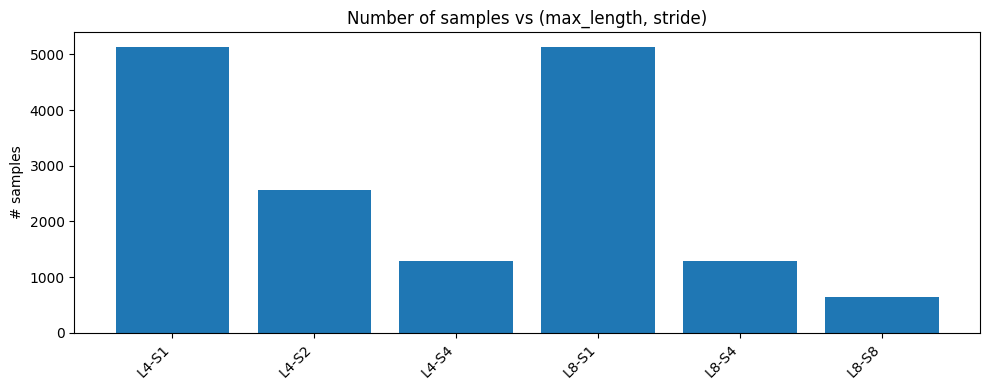

In [9]:
import matplotlib.pyplot as plt

def count_samples(txt: str, max_length: int, stride: int) -> int:
    ds = GPTDatasetV1(txt, tiktoken.get_encoding("gpt2"), max_length=max_length, stride=stride)
    return len(ds)

configs = [
    (4, 1),
    (4, 2),
    (4, 4),
    (8, 1),
    (8, 4),
    (8, 8),
]

results = []
for max_len, stride in configs:
    n = count_samples(raw_text, max_length=max_len, stride=stride)
    results.append({"max_length": max_len, "stride": stride, "samples": n})

# Print a compact table
print("max_length\tstride\tsamples")
for r in results:
    print(f"{r['max_length']}\t\t{r['stride']}\t\t{r['samples']}")

labels = [f"L{r['max_length']}-S{r['stride']}" for r in results]
values = [r["samples"] for r in results]

plt.figure(figsize=(10, 4))
plt.bar(labels, values)
plt.title("Number of samples vs (max_length, stride)")
plt.ylabel("# samples")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()